# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.



In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from rich.console import Console
from rich.table import Table

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
file_name = '/content/drive/MyDrive/ML/data/tweet_sentiment_train.csv'

In [5]:
raw_df = pd.read_csv(file_name, encoding='utf-8')

In [6]:
raw_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
raw_df = raw_df.dropna()

In [9]:
raw_df.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11117


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [10]:
raw_df['sentiment'].nunique()

3

In [11]:
raw_df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [12]:
raw_df['sentiment'].value_counts(normalize=True).mul(100).round(2)

,proportion
sentiment,
neutral,40.45
positive,31.23
negative,28.32


In [13]:
raw_df['text_len'] = raw_df['text'].str.len()
raw_df['text_len']

,text_len
0,36
1,46
2,25
3,31
4,75
...,...
27476,77
27477,122
27478,111
27479,27


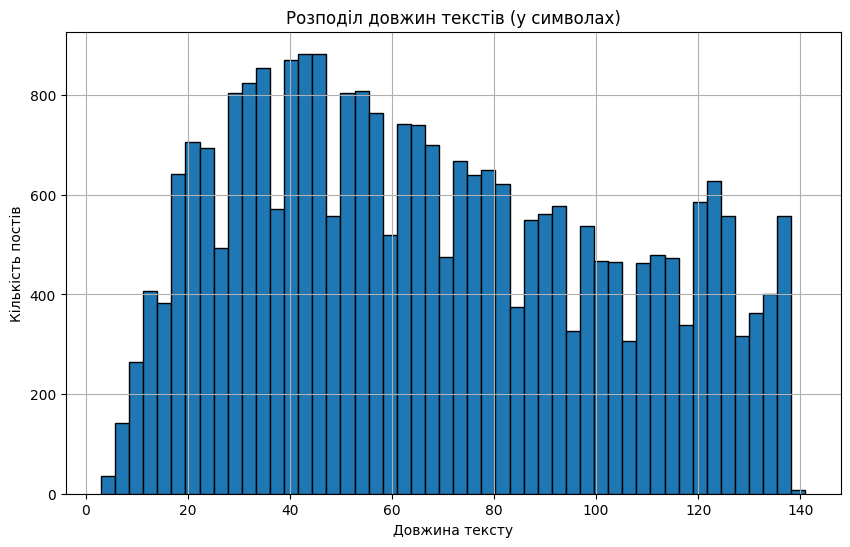

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(raw_df['text_len'], bins=50, edgecolor='black')
plt.title('Розподіл довжин текстів (у символах)')
plt.xlabel('Довжина тексту')
plt.ylabel('Кількість постів')
plt.grid(True)
plt.show()

**Спостерженя**:

- Бачимо, що загалом пости не дуже довгі, і можна сказати, що переважають більш короткі, хоча і довгі пости також зустрічаються. Можмо говорити що основна більшість постів лежить в межах приблизно 20-80.
- Розподіл не симетричний, правий хвіст поступово зменшується.

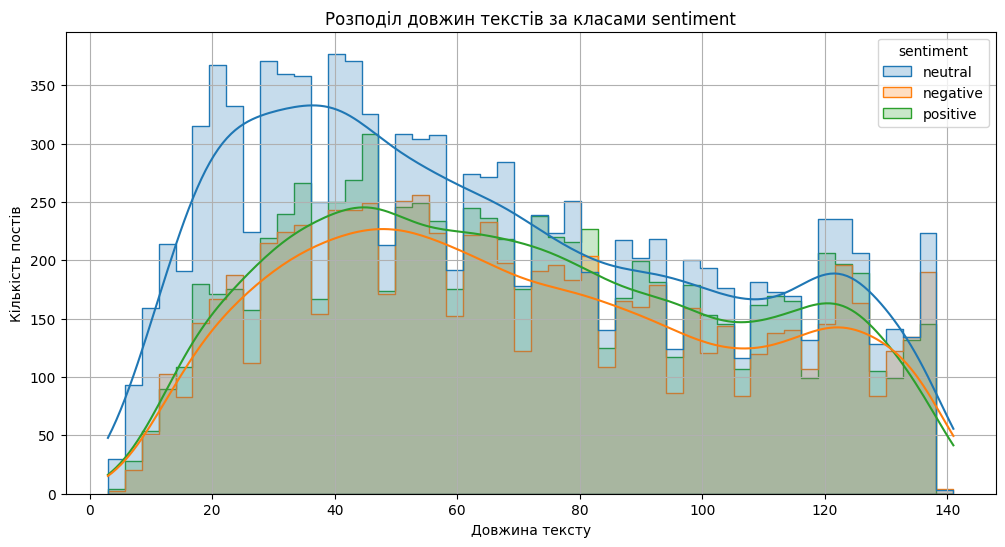

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(data=raw_df, x='text_len', hue='sentiment', bins=50, kde=True, element="step")
plt.title('Розподіл довжин текстів за класами sentiment')
plt.xlabel('Довжина тексту')
plt.ylabel('Кількість постів')
plt.grid(True)
plt.show()

**Спостереження**:

- Бачимо, що кількість нейтральних текстів переважає. Пік розподілу чітко зміщений уліво, отже більшість нейтральних постів короткію.
- Клас позитивних текстів більш рівномірний, частіше тексти довші за нейтральні.
- Негативні тексти мають меншу кількість постів у загальному, розподіл вцілому схожий на розподіл пощитивних текстів. Пристуні як довгі так і короткі пости.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [16]:
df = raw_df.copy()

In [17]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<.*?>|http\S+|www\S+|\d+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [18]:
df["cleaned_text"] = df["text"].apply(clean_text)
df["cleaned_text"]

,cleaned_text
0,i d have responded if i were going
1,sooo sad i will miss you here in san diego
2,my boss is bullying me
3,what interview leave me alone
4,sons of why couldn t they put them on the rele...
...,...
27476,wish we could come see u on denver husband los...
27477,i ve wondered about rake to the client has mad...
27478,yay good for both of you enjoy the break you p...
27479,but it was worth it


In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop_words = set(stopwords.words("english"))

In [21]:
print(stop_words)

{'under', 'me', 'why', 'that', "you'll", "you're", 'about', 'don', 'more', 'shan', 'for', 'or', 'after', 'yourselves', 'all', 'it', 'himself', 'before', 'no', 'haven', "doesn't", 'during', 'such', 'yours', 'with', "hasn't", 'her', 'ain', 'then', "we've", 'an', 'above', 'can', 'off', 'from', 'are', 'they', 'hadn', 'doesn', 'didn', "don't", "he'd", 'both', 'now', 'own', 't', 'ourselves', 'do', 'theirs', 'where', 'you', "should've", 'was', 'same', 'wouldn', 'wasn', 'these', 'at', 'who', "won't", 'doing', 'between', 'we', 'needn', "mightn't", 'aren', "hadn't", 'how', 'itself', 'd', 'here', 'some', 'herself', "it'd", 'this', 'too', 'will', 'over', 'against', 'the', 'ma', 'been', 'below', "we'd", "she's", 'does', 'being', "i've", 'mightn', 'y', 'whom', 'themselves', 'again', 'them', 'll', 'than', "wouldn't", 'other', 'hers', 'm', 'yourself', 'a', 'were', 'those', 'but', 'and', 'o', 'myself', 'isn', 'having', 'very', 'most', 'as', 'each', "i'd", 'on', 'nor', 'further', "she'll", 'its', "could

In [22]:
def remove_stopwords(text):
    if isinstance(text, str):
        tokens = text.lower().split()
        return [word for word in tokens if word not in stop_words]
    return []

In [23]:
stemmer = SnowballStemmer("english")
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

In [24]:
def process_text(text: str):
    cleaned = clean_text(text)
    tokens = remove_stopwords(cleaned)
    stemmed = stem_tokens(tokens)
    return stemmed

In [25]:
df["processed_tokens"] = df["text"].fillna("").apply(process_text)
df[["text", "processed_tokens"]].head(10)

,text,processed_tokens
0,"I`d have responded, if I were going","[respond, go]"
1,Sooo SAD I will miss you here in San Diego!!!,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,"[boss, bulli]"
3,what interview! leave me alone,"[interview, leav, alon]"
4,"Sons of ****, why couldn`t they put them on t...","[son, put, releas, alreadi, bought]"
5,http://www.dothebouncy.com/smf - some shameles...,"[shameless, plug, best, ranger, forum, earth]"
6,2am feedings for the baby are fun when he is a...,"[feed, babi, fun, smile, coo]"
7,Soooo high,"[soooo, high]"
8,Both of you,[]
9,Journey!? Wow... u just became cooler. hehe....,"[journey, wow, u, becam, cooler, hehe, possibl]"


In [26]:
df["text_processed_str"] = df["processed_tokens"].apply(lambda x: ' '.join(x))

#### Додатковий аналіз

In [27]:
class TokenFrequencyAnalyzer:
    def __init__(self, list_of_tokens):
        self.freq_dict = self._count_tokens(list_of_tokens)

    def _count_tokens(self, tokens):
        freq = {}
        for token in tokens:
            if token:
                freq[token] = freq.get(token, 0) + 1
        return freq

    def top_n(self, n=20):
        sorted_items = sorted(self.freq_dict.items(), key=lambda x: x[1], reverse=True)
        return sorted_items[:n]

    def to_dataframe(self):
        return pd.DataFrame(list(self.freq_dict.items()), columns=["token", "count"]).sort_values(by="count", ascending=False)

    def plot_distribution(self, loglog=False, top=None):
        values = sorted(self.freq_dict.values(), reverse=True)
        if top:
            values = values[:top]
        plt.figure(figsize=(10, 5))
        plt.plot(values)
        if loglog:
            plt.yscale("log")
            plt.xscale("log")
            plt.title("Token Frequency Distribution (log-log scale)")
        else:
            plt.title("Token Frequency Distribution")
        plt.xlabel("Token rank")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [28]:
def count_tokens(tokens: list) -> dict:
    freq_dict = {}
    for token in tokens:
        if token in freq_dict:
            freq_dict[token] += 1
        else:
            freq_dict[token] = 1
    return freq_dict


In [29]:
all_tokens = df["processed_tokens"].dropna().tolist()
flat_tokens = [token for sublist in all_tokens for token in sublist if token]
analyzer = TokenFrequencyAnalyzer(flat_tokens)
print("Top-20 tokens:")
for token, count in analyzer.top_n(20):
    print(f"{token:>12} — {count}")

Top-20 tokens:
         day — 2497
          go — 2384
         get — 1917
        good — 1599
        work — 1529
        love — 1484
        like — 1462
       today — 1155
        time — 1104
         got — 1099
         one — 1076
         lol — 1029
       happi — 1013
        want — 991
       thank — 990
        know — 980
           u — 969
        miss — 966
        back — 920
      realli — 916


In [30]:
token_analyzed = analyzer.to_dataframe()
token_analyzed

,token,count
79,day,2497
1,go,2384
46,get,1917
343,good,1599
162,work,1529
...,...,...
10658,flair,1
2328,congradt,1
2325,deg,1
2322,jaiden,1


Побудуємо графік частот токенів, щоб візуально оцініти загальний розподіл токенів та перевірити на даних дію закону Ципфа.

X-вісь: ранг токена — тобто його позиція в упорядкованому списку токенів за частотою;  Y — частота токену.

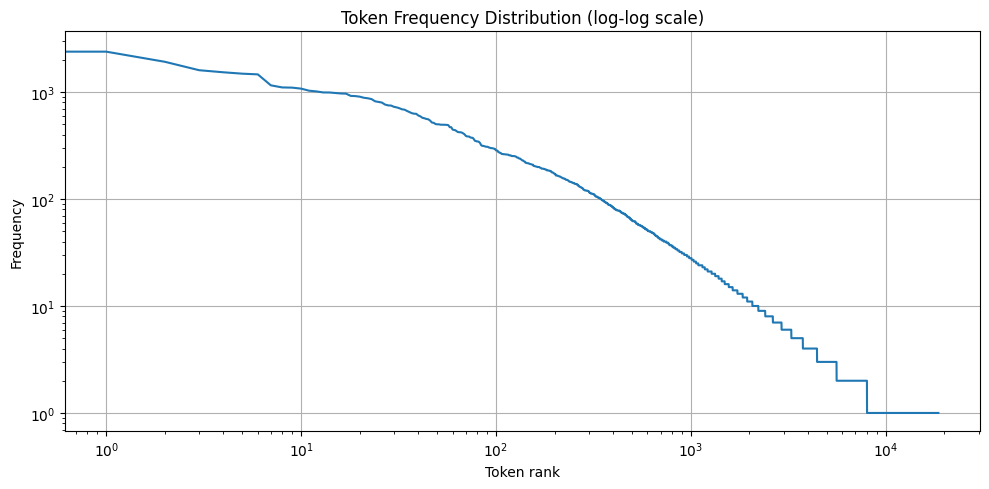

In [31]:
analyzer.plot_distribution(loglog=True)

Спостереження:
 - Можемо бачити "плато" для рангів 1-10 - токени з найвищою частотою, повторення яких більше 1000.
 - Для рангу 10-1000 - бачисо більш плавний спад, слова, що з'являються регулярно, але не є надзвичайно частими.
 - Бачимо хвіст розподілу для рангів 1000+ частоти падають нижче 10 - отже рідкісні слова, варіації, специфічні терміни тощо.
 - Кінець зхвоста - токени з'являються 1 раз, виглядає як шум, отже їх можна відсіювати.

#### Застосування CountVectorizer

Є сенс встановити min_df=2 або 3, щоб відкинути найрідкісніші слова.
Встановлення max_features=3000 або 4000 — дозволить зберегти найінформативнішу частину словника.

In [32]:
vectorizer = CountVectorizer(
    tokenizer=process_text,
    max_features=4000,
    min_df=2
)

X_bow = vectorizer.fit_transform(df["text"].fillna(""))
bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

In [33]:
bow_df.shape

(27480, 4000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [34]:
y = df["sentiment"]

X_train_bow, X_test_bow, y_train, y_test, idx_train, idx_test = train_test_split(
    X_bow, y, range(len(df)), test_size=0.2, random_state=42, stratify=y
)

(X_train_bow.shape, X_test_bow.shape, y_train.shape, y_test.shape)

((21984, 4000), (5496, 4000), (21984,), (5496,))

In [35]:
log_reg_model =  LogisticRegression(max_iter=1000)
des_tree_model = DecisionTreeClassifier(random_state=42)
grad_boost = GradientBoostingClassifier(random_state=42)
xg_boost = xgb.XGBClassifier(random_state=42)

In [36]:
models = {
    "Logistic Regression": log_reg_model,
    "Decision Tree": des_tree_model,
    "Gradient Boosting": grad_boost,
    "XGBoost ": xg_boost
}

In [37]:
y_test.unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [38]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [39]:
def binarize_labels(y_train, y_test):
    lb = LabelBinarizer()
    y_train_bin = lb.fit_transform(y_train)
    y_test_bin = lb.transform(y_test)
    is_multiclass = y_train_bin.shape[1] > 1
    return y_train_bin, y_test_bin, is_multiclass

In [40]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

In [41]:
def compute_roc_auc(y_true_bin, y_proba):
    return roc_auc_score(y_true_bin, y_proba, multi_class='ovr')

In [42]:
def evaluate_model_auc(model, X_train, y_train, X_test, y_test):
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    y_train_bin, y_test_bin, is_multiclass = binarize_labels(y_train, y_test)
    roc_train = compute_roc_auc(y_train_bin, y_train_proba)
    roc_test = compute_roc_auc(y_test_bin, y_test_proba)

    return {
        "ROC-AUC Train": round(roc_train, 4),
        "ROC-AUC Test": round(roc_test, 4)
    }


In [43]:
results = {}
for name, model in models.items():
    trained = train_model(model, X_train_bow, y_train)
    results[name] = evaluate_model_auc(trained, X_train_bow, y_train, X_test_bow, y_test)

In [44]:
console = Console()
table = Table(title="ROC-AUC Evaluation Results")

table.add_column("Model", style="cyan", no_wrap=True)
table.add_column("ROC-AUC Train", justify="center")
table.add_column("ROC-AUC Test", justify="center")

for model, scores in results.items():
    table.add_row(model, f"{scores['ROC-AUC Train']:.4f}", f"{scores['ROC-AUC Test']:.4f}")
console.print(table)

              ROC-AUC Evaluation Results              
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model               ┃ ROC-AUC Train ┃ ROC-AUC Test ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Logistic Regression │    0.9276     │    0.8340    │
│ Decision Tree       │    0.9999     │    0.7292    │
│ Gradient Boosting   │    0.8229     │    0.8014    │
│ XGBoost             │    0.8891     │    0.8385    │
└─────────────────────┴───────────────┴──────────────┘

**Спостереження**:

- Бачимо, що Logistic Regression модель показала найкащі результати на тренувальних та тестових даних. Можемо говорити про перенавчання моделі.
- Decision Tree  показала дуже високе значення метрики ROC-AUC на тренувальних даних, близькі до 1, значно нижче значення на тестувальному наборі. Маємо явне перенавчання, пдже модель запам'ятала дані.
- Gradient Boosting модель є найстабільнішою, модель краще узагальнює, має наймешше перенавчання.
- XGBoost модель має найвище значення метрики ROC-AUC на тестових даних. Маємо перенавчання. Доцільно спробувати оптимізувати гіперпараметри.

###### Заради експерименту підберемо за допомогою RandomizedSearchCV оптимальні параметри для XGBoost.

In [45]:
%%time
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0]
}

xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc_ovr',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train_bow, y_train)

best_xgb_model = xgb_search.best_estimator_
best_xgb_params = xgb_search.best_params_
best_xgb_score = xgb_search.best_score_

best_xgb_params, round(best_xgb_score, 4)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 33.8 s, sys: 576 ms, total: 34.4 s
Wall time: 3min 55s


({'subsample': 1.0,
  'reg_lambda': 1.5,
  'reg_alpha': 1.0,
  'n_estimators': 500,
  'max_depth': 8,
  'learning_rate': 0.05,
  'gamma': 0.3,
  'colsample_bytree': 0.7},
 np.float64(0.8371))

In [46]:
tuned_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    **best_xgb_params
)

In [47]:
tuned_xgb.fit(X_train_bow, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [48]:
y_train_proba = tuned_xgb.predict_proba(X_train_bow)
y_test_proba = tuned_xgb.predict_proba(X_test_bow)

In [49]:
roc_train = roc_auc_score(y_train, y_train_proba, multi_class='ovr')
roc_test = roc_auc_score(y_test, y_test_proba, multi_class='ovr')

In [50]:
print(f"ROC-AUC тренувальний набір: {roc_train}")
print(f"ROC-AUC тестувальний набір: {roc_test}")

ROC-AUC тренувальний набір: 0.886426122156032
ROC-AUC тестувальний набір: 0.8402516905874388


**Спостереження**:

Бачимо, що після тюнингу XGBoost моделі суттєвого покращення не відбулось, але зменшилилась різниця значень метрики між тренувальним та тестовим наборах даних. Отже можемо як найкращу обрати модель XGBoost з тюнингом гіперпараметрів так і звичайну XGBoost. Але для корректного порівнняня в наступних завданнях, за найкращу примаємо XGBoost з базовими налаштуваннями.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


Оскільки нам важливо буде порвняння з TF-IDF. Розгянемо звичайну модель XGBoost без підбору гіперпараметрів.

In [51]:
feature_importances = xg_boost.feature_importances_
feature_importances

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [52]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['aaaah', 'aah', 'aaron', ..., 'zombi', 'zone', 'zoo'], dtype=object)

In [53]:
importance_df = pd.DataFrame({
    'token': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

In [54]:
top_important_tokens = importance_df.head(20).reset_index(drop=True)

In [55]:
top_important_tokens

,token,importance
0,happi,0.017748
1,thank,0.016954
2,hate,0.010595
3,amaz,0.009721
4,nice,0.009513
5,love,0.009346
6,awesom,0.008898
7,bore,0.008667
8,ugh,0.008426
9,sad,0.008096


**Спостереження**:

Бачимо, що серед важливих токенів є як позитивні, так і негативні слова. Загалом, аналіз важливості токенів підтверджує логічність роботи моделі: найбільший внесок мають слова, які явно виражають емоції.


##### Додатково проаналізуємо важливість ознак та помилки для моделі XGBoost з підбором гіперпараметрів

In [56]:
feature_importances_ = tuned_xgb.feature_importances_
feature_importances_

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [57]:
importance_df = pd.DataFrame({
    'token': feature_names,
    'importance': feature_importances_
}).sort_values(by='importance', ascending=False)

In [58]:
top_important_tokens_ = importance_df.head(20).reset_index(drop=True)

In [59]:
top_important_tokens_

,token,importance
0,thank,0.020277
1,happi,0.019054
2,love,0.011969
3,hate,0.010746
4,hurt,0.010378
5,amaz,0.010195
6,nice,0.009667
7,sad,0.009201
8,awesom,0.009060
9,suck,0.008512


**Спостереження**:

Бачимо, для тюнингованої моделі, важливість токенів дещо інша ніж для звичайної XGBoost моделі. Але також серед найважливіших токенів ті, що відображають емоції.


In [60]:
y_pred = tuned_xgb.predict(X_test_bow)
y_proba = tuned_xgb.predict_proba(X_test_bow)
confidence = y_proba.max(axis=1)
confidence

array([0.520071  , 0.81206936, 0.75944626, ..., 0.50421494, 0.57826805,
       0.98390466], dtype=float32)

In [61]:
error_analysis_df = pd.DataFrame({
    "text": df.loc[idx_test, "text"].values,
    "true_label": label_encoder.inverse_transform(y_test),
    "predicted_label": label_encoder.inverse_transform(y_pred),
    "confidence": confidence
})
error_analysis_df

,text,true_label,predicted_label,confidence
0,ME TOO UGH,negative,neutral,0.520071
1,Stu Lantz is awesome! I miss Chick Hearn tho,negative,negative,0.812069
2,nai nai baby. haha i didn`t know that you hav...,negative,negative,0.759446
3,"getting ready to go read, pray, and go to bed....",negative,negative,0.897004
4,this traffic is ridiculous im may not make it,positive,positive,0.529722
...,...,...,...,...
5491,Then Google Vs. Twitter . Mother`s Day Vs. M...,positive,neutral,0.627765
5492,has toothache,neutral,neutral,0.540886
5493,Or maybe its just us ....,negative,positive,0.504215
5494,Sitting waiting for dough to rise. There`s som...,neutral,neutral,0.578268


In [62]:
errors_only = error_analysis_df[error_analysis_df["true_label"] != error_analysis_df["predicted_label"]]
errors_only = errors_only.sort_values(by="confidence", ascending=False).reset_index(drop=True)
errors_only.shape

(1672, 4)

In [63]:
errors_only.head(10)

,text,true_label,predicted_label,confidence
0,I want some ice cream,neutral,positive,0.974435
1,thank you,neutral,positive,0.955873
2,really was the best night ever,neutral,positive,0.953943
3,_Sprigge Keen skydivers take off thousands of...,neutral,positive,0.949749
4,"impressive fever! best wishes to her, hope i...",neutral,positive,0.949164
5,hey is there a way u can make a somatic theme...,neutral,positive,0.942871
6,pics arent working for me here on twitter,neutral,positive,0.942519
7,I need some DRANK & 'GRAPE KONTAKT' from my gi...,neutral,negative,0.939296
8,bath time,neutral,positive,0.936776
9,got it i`ll send you an email in a lil bit i ...,neutral,positive,0.928109


Проаналізуємо випадки з помилок, коли модель визначила текст як позитивний, але він мав негативну мітку, і навпаки, коли позитивний текст був класифікований як негативний.

Випадки, де негативий класс передбачили як позитивний:

In [64]:
false_pos_from_neg = error_analysis_df[
    (error_analysis_df["true_label"] == "negative") &
    (error_analysis_df["predicted_label"] == "positive")
].sort_values(by="confidence", ascending=False)

false_pos_from_neg.head(10)

,text,true_label,predicted_label,confidence
4575,_are_fire Hii,negative,positive,0.898798
737,spray tan = fail on legs and feet. I`ve been s...,negative,positive,0.817870
3563,Thanks so much!,negative,positive,0.790613
5249,**** it. Totally gutted I decided not to go ou...,negative,positive,0.760541
4287,just dropped my biscuit in my tea,negative,positive,0.753721
3006,finally Mike0hh`s birthday <3 can`t wait to **...,negative,positive,0.749279
3687,hahaha. I think you`re pretty far from me. Ma...,negative,positive,0.734952
2702,i realy wanted to go out cause its so nice but...,negative,positive,0.724579
1790,http://tinyurl.com/cyonct vote for Rob,negative,positive,0.715851
2085,isnt going to the movies!! i got grounded,negative,positive,0.714281


In [65]:
false_pos_from_neg.shape

(95, 4)

Випадки, де позитивний класс передбачили як негативий:

In [66]:
false_neg_from_pos = error_analysis_df[
    (error_analysis_df["true_label"] == "positive") &
    (error_analysis_df["predicted_label"] == "negative")
].sort_values(by="confidence", ascending=False)

false_neg_from_pos.head(10)

,text,true_label,predicted_label,confidence
3602,Wishing the rain would stay away for a while s...,positive,negative,0.915606
2386,Ahhh! I knowww! I saw it May 5th and 6th in ...,positive,negative,0.872024
539,almost died. Laptop screen was set to 100% bri...,positive,negative,0.870476
1792,congratulations! woootwoooo! great game! n...,positive,negative,0.830311
2037,playing singstar without my fave duetter,positive,negative,0.810565
199,UGH I HATE QUEUEING,positive,negative,0.790308
2164,http://twitpic.com/67jq9 - i`m really missing ...,positive,negative,0.763802
759,"awww, that sucks But they`re so awesome when...",positive,negative,0.748298
2623,that`s because of all the stuff that was stol...,positive,negative,0.729531
3618,"will do hee after exams, i`ll give u plenty ...",positive,negative,0.724806


In [67]:
false_neg_from_pos.shape

(60, 4)

**Спостереження**:

В ході аналізу помилок моделі, можемо побачити, що дуже часто модель класифікує позитивний клас як негативний і негативний як позитивний у випадках, коли зустрічаються позитивні/негативні ключові слова, спримаючи їх буквально не розпізнавши іронічний підтекст.


|index|text|true\_label|predicted\_label|confidence|
|---|---|---|---|---|
|4575| yeah it made a great noise, and tripped the house circuit breaker\. Good Times\. $200 worth of parts too|negative|positive|0\.8987979292869568|


Незважаючи на присутність слів “great” і “good”, коментар розмічено як негативний, отже, зміст коментаря - негативний. Модель сконцетрувалася на позитивних словах.


Також модель не враховує вираз емпатії, так наприклад, модель трактує слова “sorry”, “loss” як індикатори негативу, хоча пост висловлює підтримку.


|index|text|true\_label|predicted\_label|confidence|
|---|---|---|---|---|
|1792| Sorry for your loss\.  I know how you feel\.  She or he was a lucky cat\.|positive|negative|0\.8303113579750061|



Більшість помилок, що зробила модель повязана з некоретним передбаченням нейтрального забарвлення тексту, тоюто або позитивний/негативний коментар був відмічено нейтрально чи навпаки нейтральний текст був визначений моделлю більше як позитивний/негативний.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [68]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=process_text,
    max_features=4000,
    min_df=2
)
X_tfidf = tfidf_vectorizer.fit_transform(df["text"].fillna(""))
X_tfidf.shape

(27480, 4000)

In [69]:
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

Розділяємо X_tfidf на train/test за збереженими індексами

In [70]:
X_train_tfidf = X_tfidf[idx_train]
X_test_tfidf = X_tfidf[idx_test]

In [71]:
xgb_tfidf = xgb.XGBClassifier(random_state=42)

In [72]:
xgb_tfidf = train_model(xgb_tfidf, X_train_tfidf, y_train)
results = evaluate_model_auc(xgb_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)

In [73]:
results

{'ROC-AUC Train': np.float64(0.9097), 'ROC-AUC Test': np.float64(0.8398)}

**Спостереження**:

- Бачимо, що якість практично не змінилася, все ще присутня проблема перенавчання моделі. Діапазон значень метрик залишається на тому ж рівні.

In [74]:
feature_importances_tfidf_ = xgb_tfidf.feature_importances_
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

In [75]:
importance_df_tfidf = pd.DataFrame({
    'token': feature_names_tfidf,
    'importance': feature_importances_tfidf_
}).sort_values(by='importance', ascending=False)

top_important_tokens_tfidf = importance_df_tfidf.head(20).reset_index(drop=True)

In [76]:
top_important_tokens_tfidf

,token,importance
0,thank,0.013421
1,happi,0.010458
2,ugh,0.010210
3,hate,0.009960
4,amaz,0.009737
5,suck,0.008568
6,love,0.008053
7,nice,0.007787
8,awesom,0.007687
9,sad,0.007680


**Спостереження**:

Попередньо можемо бачити, що найважливіші фічі відрізняються від минулої векторизації, але можемо зустріти багато подібних фічей. Тут можемо сказати, що фічі також більше відображають емоції та почуття.

In [77]:
tokens_bow = top_important_tokens["token"].tolist()
tokens_tfidf = top_important_tokens_tfidf["token"].tolist()

table = Table(title="Top Important Tokens: BoW vs TF-IDF")
table.add_column("Rank", justify="center")
table.add_column("BoW Token", style="cyan", justify="center")
table.add_column("TF-IDF Token", style="magenta", justify="center")

for i in range(max(len(tokens_bow), len(tokens_tfidf))):
    bow = tokens_bow[i] if i < len(tokens_bow) else ""
    tfidf = tokens_tfidf[i] if i < len(tokens_tfidf) else ""
    table.add_row(str(i + 1), bow, tfidf)

console = Console()
console.print(table)

Top Important Tokens: BoW vs TF-IDF
┏━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Rank ┃ BoW Token ┃ TF-IDF Token ┃
┡━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│  1   │   happi   │    thank     │
│  2   │   thank   │    happi     │
│  3   │   hate    │     ugh      │
│  4   │   amaz    │     hate     │
│  5   │   nice    │     amaz     │
│  6   │   love    │     suck     │
│  7   │  awesom   │     love     │
│  8   │   bore    │     nice     │
│  9   │    ugh    │    awesom    │
│  10  │    sad    │     sad      │
│  11  │   hurt    │     hurt     │
│  12  │   suck    │     cute     │
│  13  │   cool    │     fail     │
│  14  │   enjoy   │     cri      │
│  15  │   fail    │    enjoy     │
│  16  │   poor    │    great     │
│  17  │   great   │     sick     │
│  18  │   excit   │     poor     │
│  19  │   cute    │    excit     │
│  20  │   sick    │     miss     │
└──────┴───────────┴──────────────┘

**Спостереження**:

- Більшість токенів зустрічаються як найважливіші для обох векторизацій. Отже можемо сказати, що незалежно від підходу до векторизації, ключові емоційно забарвлені слова залишаються найважливішими для класифікації. Дещо відрізняєть важливість та приоритетність токенів для BoW та TF-IDF.

Візуалізуємо важливість спільних токенів для BoW та TF-IDF:

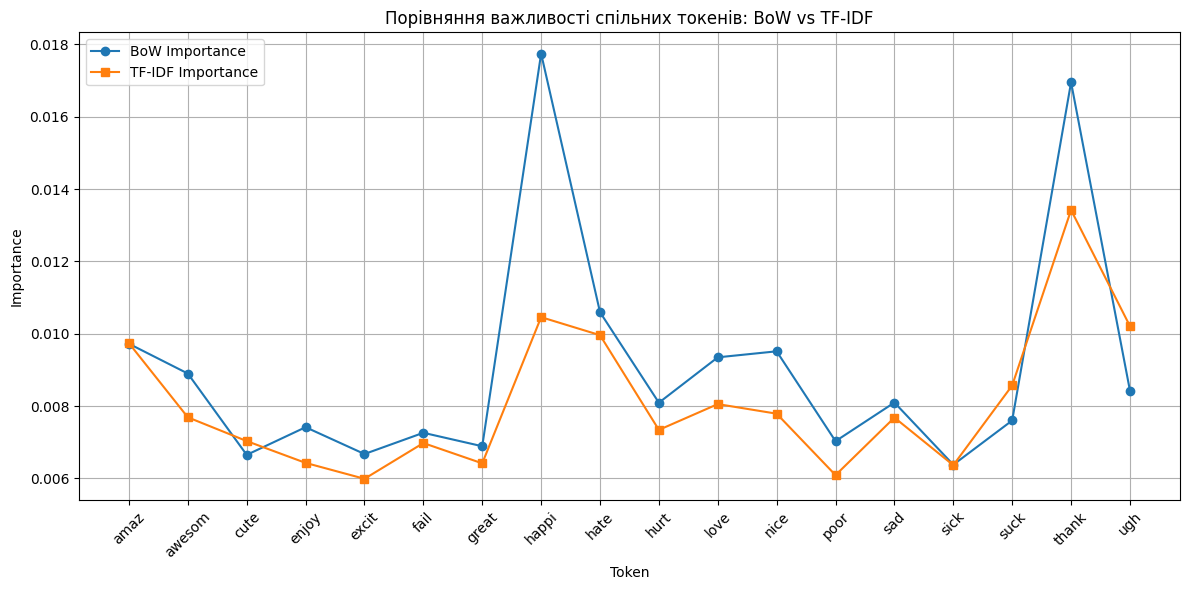

In [78]:
tokens_bow = top_important_tokens["token"].tolist()
tokens_tfidf = top_important_tokens_tfidf["token"].tolist()

common_tokens = set(tokens_bow) & set(tokens_tfidf)

importance_bow = dict(zip(top_important_tokens["token"], top_important_tokens["importance"]))
importance_tfidf = dict(zip(top_important_tokens_tfidf["token"], top_important_tokens_tfidf["importance"]))

tokens = sorted(common_tokens)
bow_values = [importance_bow[token] for token in tokens]
tfidf_values = [importance_tfidf[token] for token in tokens]

plt.figure(figsize=(12, 6))
x = range(len(tokens))
plt.plot(x, bow_values, marker='o', label='BoW Importance')
plt.plot(x, tfidf_values, marker='s', label='TF-IDF Importance')
plt.xticks(x, tokens, rotation=45)
plt.title("Порівняння важливості спільних токенів: BoW vs TF-IDF")
plt.xlabel("Token")
plt.ylabel("Importance")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

**Спостреження**:

Бачимо, що тенденція вцілому подібна. Для BoW маємо більшу важивість таких токенів як `happi`, `thank`, `nice`. TF-IDF підсилює важливість таких слів як:
`cute`, `suck`, `ugh`.

**Вибір векторизації для фінального рішення**

Для фінальної імплементації я б обрала TF-IDF векторизацію, хоча доцільно було б ще продивитится помилки моделі з даною векторизацію, оскільки зважаючи на них можна припустити, що модель може не відчути з тексту. На даний момент маю гіпотезу, що TF-IDF може більше розрізнити емоційних відтінків, оскільки вона має вищі значенння важливості, для токенів, що описують глибші почуття типу `miss`, `cute`, отже потенційно може краще врахувати контекст.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [79]:
y_pred_tfidf = xgb_tfidf.predict(X_test_tfidf)
y_proba_tfidf = xgb_tfidf.predict_proba(X_test_tfidf)
confidence_tfidf = y_proba_tfidf.max(axis=1)

In [80]:
error_analysis_df_tfidf = pd.DataFrame({
    "text": df.loc[idx_test, "text"].values,
    "true_label": label_encoder.inverse_transform(y_test),
    "predicted_label": label_encoder.inverse_transform(y_pred_tfidf),
    "confidence": confidence_tfidf
})
error_analysis_df_tfidf

,text,true_label,predicted_label,confidence
0,ME TOO UGH,negative,neutral,0.536856
1,Stu Lantz is awesome! I miss Chick Hearn tho,negative,negative,0.826751
2,nai nai baby. haha i didn`t know that you hav...,negative,negative,0.529714
3,"getting ready to go read, pray, and go to bed....",negative,negative,0.982480
4,this traffic is ridiculous im may not make it,positive,neutral,0.405924
...,...,...,...,...
5491,Then Google Vs. Twitter . Mother`s Day Vs. M...,positive,neutral,0.634093
5492,has toothache,neutral,neutral,0.550911
5493,Or maybe its just us ....,negative,positive,0.549591
5494,Sitting waiting for dough to rise. There`s som...,neutral,neutral,0.455372


In [81]:
errors_only_tfidf = error_analysis_df_tfidf[
    error_analysis_df_tfidf["true_label"] != error_analysis_df_tfidf["predicted_label"]
].sort_values(by="confidence", ascending=False).reset_index(drop=True)
errors_only_tfidf.head(10)

,text,true_label,predicted_label,confidence
0,My best friend is away at special olympics . S...,neutral,negative,0.974759
1,i`m on twitter! go me. i have no idea how to ...,neutral,positive,0.963218
2,Working on some Product Buzz (product reviews)...,neutral,positive,0.960955
3,Finally lost FM97,neutral,positive,0.957852
4,bath time,neutral,positive,0.952688
5,my mum would be happy to receive 2 handbags an...,neutral,positive,0.951142
6,YEHEY SUMMER!! so exciteeeddd.. balme it on t...,neutral,negative,0.950966
7,i miss rich,neutral,positive,0.945566
8,I want some ice cream,neutral,positive,0.944686
9,"impressive fever! best wishes to her, hope i...",neutral,positive,0.944051


In [82]:
errors_only_tfidf.shape

(1718, 4)

Випадки, де негативий класс передбачили як позитивний:

In [83]:
false_pos_from_neg_tfidf = error_analysis_df_tfidf[
    (error_analysis_df_tfidf["true_label"] == "negative") &
    (error_analysis_df_tfidf["predicted_label"] == "positive")
].sort_values(by="confidence", ascending=False)
false_pos_from_neg_tfidf.head(10)

,text,true_label,predicted_label,confidence
4575,_are_fire Hii,negative,positive,0.889672
5108,You know you`re up too late when the TCU night...,negative,positive,0.862961
1790,http://tinyurl.com/cyonct vote for Rob,negative,positive,0.856371
3006,finally Mike0hh`s birthday <3 can`t wait to **...,negative,positive,0.848264
3687,hahaha. I think you`re pretty far from me. Ma...,negative,positive,0.790515
652,#flylady Oh deary me: 15 mins not enough to re...,negative,positive,0.776191
2695,goodnight world.... goodnight eddplant.,negative,positive,0.766691
5277,Changing my online nickname to mtaby (which wi...,negative,positive,0.762119
2085,isnt going to the movies!! i got grounded,negative,positive,0.751680
3563,Thanks so much!,negative,positive,0.749305


In [84]:
false_pos_from_neg_tfidf.shape

(89, 4)

**Спостереження**:

- Бачимо, що наприклад вираз `Thanks so much!` має мітку як негативну, але модель передбачила цей вираз як позитивний, ймовірно, базуючись на тому що загалом цей вираз позитивний, не врахувавши, що тут може бути саркастичний підтекст.
- Загалом модель орієнтується на позитивні слова, при визначення тексту, як позитивного.


Випадки, де позитивний класс передбачили як негативий:

In [85]:
false_neg_from_pos_tfidf = error_analysis_df_tfidf[
    (error_analysis_df_tfidf["true_label"] == "positive") &
    (error_analysis_df_tfidf["predicted_label"] == "negative")
].sort_values(by="confidence", ascending=False)
false_neg_from_pos_tfidf.head(10)

,text,true_label,predicted_label,confidence
3602,Wishing the rain would stay away for a while s...,positive,negative,0.909452
2164,http://twitpic.com/67jq9 - i`m really missing ...,positive,negative,0.851923
1792,congratulations! woootwoooo! great game! n...,positive,negative,0.849356
199,UGH I HATE QUEUEING,positive,negative,0.847811
3618,"will do hee after exams, i`ll give u plenty ...",positive,negative,0.811713
539,almost died. Laptop screen was set to 100% bri...,positive,negative,0.768254
3591,Oh.... great. I think I`m getting sick.,positive,negative,0.762554
1397,Good Morning twitters!!! I am soooo tired...I ...,positive,negative,0.732090
2386,Ahhh! I knowww! I saw it May 5th and 6th in ...,positive,negative,0.724247
5289,: 3 hrs to go pa ako,positive,negative,0.713630


In [86]:
false_neg_from_pos_tfidf.shape

(56, 4)

**Спостереження**:

- Здається, що можемо мати певні неожнозначності в даних, адже
`Oh.... great. I think I am getting sick.` це вже негативний фізичний стан, але мітка — позитивна. `"UGH I HATE QUEUEING"` — явно негативна лексика, але марковано як positive, і модель передбавила як негативне речення.

**Загальне спостереження**:
Загалом, деякі мітки у датасеті можуть бути суб’єктивними або помилковими. Модель часто не може визначити сарказм або іронію. Коментарі із змішаними емоціями викликають плутанину, адже модель фокусується лише на ключових словах.

**Шляхи поліпшення якості класифікації**:

1. Бачимо, що TF-IDF і BoW ігнорують контекст та порядок слів, що критично важливо для розуміння емоцій. Модель фокусується на словах, які взалежності від контексту можуть змінювати свое емоційне забарвлення. Багато помилок моделі пов'язані з нездатністю розпізнати сарказм, ностальгію, тон і багатозначність. В такому випадку нам треба знайти механізм, який міг би допомогти враховувати контекст і порядок слів у черенні, це могло б допомогти зменшити такого роду помилки.

2. Було б доцільно попрацювати над фіча інжинірингом, щоб підвищии чутливість моделі до щмішаних, або прихованих емоцій. Модель добре виявляє часто вживані емоційні слова, але не завжди вловлює менш часті, але ключові маркери почуттів.

3. Аналіз та прокращення якості розмітки. Частина помилок моделі, ймовірно, викликана неконсистентністю міток.
> Наприклад, `“Thanks so much!”` із негативною міткою.



І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model